### Weekly TCM Report

Click Cell-> "Run All" to refresh

In [65]:
# Loading libraries
#import boto3
#import pandas as pd
#from io import StringIO
#from math import floor
#import matplotlib.pyplot as plt
#import datetime
#import warnings
#from IPython.display import HTML

Report Date: March 23, 2019

Capacity: 2356
Bookings: 1674
Fill Rate: 71.1%
Avg Revenue: $2112


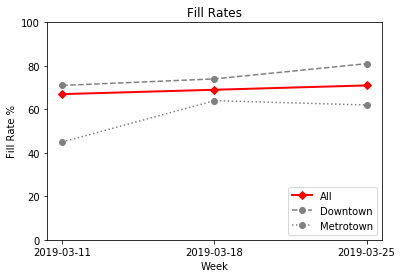

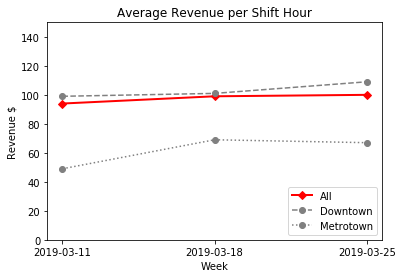

                Clinician  Revenue  RevPerHour  FillRate  ThisWeek  LastWeek
0       Dr. Byoung Jin NA     8030         203        95         1         1
1  Hoon il (Melanie) Kwak     7000         200       100         2         2
2           Dr. Ryan Funk     6175         162        86         3         3
3               Suka Lang     5750         216        94         4        10
4       Dr. Brad Matthews     5490         178       100         5         8
5            Kelli Taylor     4935         189        92         6         6
6        Dr. Keema Shield     4750         250       100         7         7
7           Olivier Barre     4715         115       100         8        11
8          Mr. Duyong Lee     4410          97        97         9        15
9       Dr. Sung Soo Yoon     4180          87        79        10        14


In [66]:
# Printing today's date
print("Report Date: " + datetime.datetime.date(datetime.datetime.now()).strftime("%B %d, %Y"))
print()

# Disabling Warnings
warnings.filterwarnings("ignore")

# Defining paths
myBucket = 'tcmbooking'

# Function which returns lists of errors, openings and shifts in s3 bucket
def get_tcm_files(bucket):
    """Get a list of keys in an S3 bucket"""
    errors = []
    openings = []
    shifts = []
    
    resp = s3.list_objects_v2(Bucket=bucket)
    for x in resp['Contents']:
        if "error" in x['Key']:
            errors.append(x['Key'])
        elif "openings" in x['Key']:
            openings.append(x['Key'])
        elif "shifts" in x['Key']:
            shifts.append(x['Key'])
        
    return errors, openings, shifts

# Function to choose the shift duration to be used in future calculations
def getHours(row):
    if row['Duration'] > row['maxHours']:
        val = row['maxHours']
    else:
        val = row['Duration']
        
    return val

# Function to choose the shift duration to be used in future calculations
def getStartOfWeek(weekNo):
    x = datetime.datetime.strptime('2019-W' + str(weekNo) + '-1', '%Y-W%W-%w').strftime('%Y-%m-%d')
    return x

# Getting list of files in s3 bucket
s3 = boto3.client('s3')
errors, openings, shifts = get_tcm_files(myBucket)

# Creating data frame of the openings
dailyOpenings = pd.DataFrame()

for x in openings:
    # Reading in data from s3
    csv_obj = s3.get_object(Bucket=myBucket, Key=x)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_string))
    
    # Selecting only same day data
    df = df.loc[df['DaysAhead']==0]
    dailyOpenings = dailyOpenings.append(df, ignore_index=True)
    
dailyOpenings.drop_duplicates(inplace=True)

# Creating data frame of the shifts
dailyShifts = pd.DataFrame()

for x in shifts:
    # Reading in data from s3
    csv_obj = s3.get_object(Bucket=myBucket, Key=x)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_string))
    
    # Selecting only same day data
    df = df.loc[df['DaysAhead']==0]
    dailyShifts = dailyShifts.append(df, ignore_index=True)
    
dailyShifts.drop_duplicates(inplace=True)

# Getting the opening time
dailyShifts['StartH'] = dailyShifts['Start'].str[:2]
dailyShifts['StartM'] = dailyShifts['Start'].str[3:]
dailyShifts['StartH'] = dailyShifts.StartH.astype(float)
dailyShifts['StartM'] = dailyShifts.StartM.astype(float)
dailyShifts['StartM'] = dailyShifts['StartM'] / 60
dailyShifts['Open']  = dailyShifts['StartH'] + dailyShifts['StartM']
dailyShifts = dailyShifts.drop(['StartH', 'StartM'], axis = 1)

# Getting the closing time
dailyShifts['CloseH'] = dailyShifts['End'].str[:2]
dailyShifts['CloseM'] = dailyShifts['End'].str[3:]
dailyShifts['CloseH'] = dailyShifts.CloseH.astype(float)
dailyShifts['CloseM'] = dailyShifts.CloseM.astype(float)
dailyShifts['CloseM'] = dailyShifts['CloseM'] / 60
dailyShifts['Close']  = dailyShifts['CloseH'] + dailyShifts['CloseM']
dailyShifts = dailyShifts.drop(['CloseH', 'CloseM'], axis = 1)

# Getting the open hours per day
openHours = dailyShifts.groupby(['URL', 'Date'], as_index=False).agg({"Open":"min", "Close":"max"})
openHours['maxHours'] = (openHours['Close'] - openHours['Open'])*60
openHours = openHours.drop(['Open', 'Close'], axis = 1)

# Joining max hours to the daily shifts data frame
dailyShifts = dailyShifts.merge(openHours, on = ['URL', 'Date'], how='left', right_index=False)

dailyShifts['WorkTime'] = dailyShifts.apply(getHours, axis = 1)

# Aggregating shifts and openings
shifts_agg = dailyShifts.groupby(['Clinician', 'Date'], as_index=False).agg({"URL": "first", "WorkTime": "sum"})
openings_agg = dailyOpenings.groupby(['Clinician', 'Date'], as_index=False).agg({"URL": "first", "Duration": "sum", "DaysAhead": "count"})

# Renaming columns to eliminate duplicates
shifts_agg.columns = ['Clinician', 'Date', 'URL', 'ShiftTime']
openings_agg.columns = ['Clinician', 'Date', 'URL', 'OpenTime', 'OpenSlots']

# Merging shifts and openings data frames
daily = shifts_agg.merge(openings_agg, on = ['Clinician', 'URL', 'Date'], how='left', right_index=False)
daily['OpenTime'] = daily['OpenTime'].fillna(0)
daily['OpenSlots'] = daily['OpenSlots'].fillna(0)

# Getting price data
prices = pd.read_csv('/home/ubuntu/getTCM/jane_url.csv')
prices.columns = ['Clinic', 'Clinician', 'URL', 'Location', 'Cost', 'ApTime', 'Area']
prices['ApTime'] = prices['ApTime'].fillna(60)
prices = prices.drop(['Clinician'], axis=1)

# Joining data frames
daily = daily.merge(prices, on = 'URL', how='left', right_index=False)
daily.drop_duplicates(inplace=True)

# Joining data frames
daily = daily.merge(openHours, on = ['URL', 'Date'], how='left', right_index=False)
daily.drop_duplicates(inplace=True)
daily['Duration'] = daily['ShiftTime']
daily['ShiftTime'] = daily.apply(getHours, axis = 1)
daily = daily.drop(['Duration', 'maxHours'], axis=1)

# Estimating revenue
daily['AllSlots'] = daily['ShiftTime'] / daily['ApTime']
daily = daily.round({'Bookings': 0})
daily['AllSlots'] = daily['ShiftTime'] / daily['ApTime']
daily['AllSlots'] = daily.AllSlots.apply(floor)
daily['BookedSlots'] = daily['AllSlots'] - daily['OpenSlots']
daily['DailyRevenue'] = daily['BookedSlots'] * daily['Cost']

# Calculating week number
daily['Week'] = pd.to_datetime(daily['Date'])
daily['Week'] = daily['Week'].dt.week

# Aggregating shifts and openings
weekly_agg = daily.groupby(['Week', 'Area'], as_index=False).agg({"Date": "first", "AllSlots": "sum", "BookedSlots":"sum", "DailyRevenue":"sum", "ShiftTime":"sum", "Clinician": pd.Series.nunique})
weekly_agg['FillRate'] = weekly_agg['BookedSlots']/weekly_agg['AllSlots']
weekly_agg['FillRate'] =100*weekly_agg['FillRate']
weekly_agg['FillRate'] = weekly_agg.FillRate.apply(floor)
weekly_agg['ShiftTime'] = round(weekly_agg['ShiftTime'] / 60, 1)
weekly_agg['AvgRevenue'] = weekly_agg['DailyRevenue'] / weekly_agg['Clinician']
weekly_agg['AvgRevenue'] = weekly_agg.AvgRevenue.apply(floor)
weekly_agg['HrRevenue'] = round(weekly_agg['DailyRevenue'] / weekly_agg['ShiftTime'],0)
weekly_agg.columns = ['Week', 'Area', 'Date', 'AllSlots', 'BookedSlots','WeeklyRevenue','WeeklyHrs', 'nPractitioner', 'FillRate', 'AvgRevenue', 'RevPerHr']

# Creating industry averages
industry_agg = daily.groupby(['Week'], as_index=False).agg({"Date": "first", "AllSlots": "sum", "BookedSlots":"sum", "DailyRevenue":"sum", "ShiftTime":"sum", "Clinician": pd.Series.nunique})
industry_agg['FillRate'] = industry_agg['BookedSlots']/industry_agg['AllSlots']
industry_agg['FillRate'] =100*industry_agg['FillRate']
industry_agg['FillRate'] = industry_agg.FillRate.apply(floor)
industry_agg['ShiftTime'] = round(industry_agg['ShiftTime'] / 60, 1)
industry_agg['AvgRevenue'] = industry_agg['DailyRevenue'] / industry_agg['Clinician']
industry_agg['AvgRevenue'] = industry_agg.AvgRevenue.apply(floor)
industry_agg['HrRevenue'] = round(industry_agg['DailyRevenue'] / industry_agg['ShiftTime'],0)
industry_agg.columns = ['Week', 'Date', 'AllSlots', 'BookedSlots','WeeklyRevenue','WeeklyHrs', 'nPractitioner', 'FillRate', 'AvgRevenue', 'RevPerHr']
industry_agg['Area'] = 'All'
industry_agg = industry_agg[['Week', 'Area', 'Date', 'AllSlots', 'BookedSlots','WeeklyRevenue','WeeklyHrs', 'nPractitioner', 'FillRate', 'AvgRevenue', 'RevPerHr']]

# Appending aggregated data frames
weekly_agg = weekly_agg.append(industry_agg, ignore_index = True)
weekly_agg['Date'] = weekly_agg.Week.apply(getStartOfWeek)
weekly_agg = weekly_agg[weekly_agg['Week']>9]

# Creating pivoted data frames
fill_pivot = weekly_agg.drop(['Week', 'AllSlots','BookedSlots','WeeklyRevenue', 'nPractitioner', 'AvgRevenue'], axis=1).pivot(index="Date", columns = "Area", values = "FillRate")
fill_pivot = fill_pivot.reset_index()

revenue_pivot = weekly_agg.drop(['Week', 'AllSlots','BookedSlots','WeeklyRevenue', 'nPractitioner', 'FillRate'], axis=1).pivot(index="Date", columns = "Area", values = "RevPerHr")
revenue_pivot = revenue_pivot.reset_index()

# Calculating KPIs
dailyX = daily[daily['Week'] == daily.Week.max()]
capacity = round(pd.Series(dailyX['AllSlots']).sum(),0)
bookings = round(pd.Series(dailyX['BookedSlots']).sum(),0)
fillRate = 100*round(bookings/capacity,3)
revenue = pd.Series(dailyX['DailyRevenue']).sum()
nPractitioner = len(dailyX.Clinician.unique())
avgRevenue = round(revenue / nPractitioner, 0)
print("Capacity: " + "{:.0f}".format(capacity))
print("Bookings: " + "{:.0f}".format(bookings))
print("Fill Rate: " + "{:.1f}".format(fillRate) + "%")
print("Avg Revenue: $" + "{:.0f}".format(avgRevenue))

# Plotting fill rates
labels = ['All', 'Downtown', 'Metrotown']
line_chart1 = plt.plot(fill_pivot.Date, fill_pivot.All, marker="D", linewidth = 2, color = 'r')
line_chart1 = plt.plot(fill_pivot.Date, fill_pivot.Downtown, marker="o", color = 'grey', label = 'Downtown', linestyle = '--')
line_chart1 = plt.plot(fill_pivot.Date, fill_pivot.Metrotown, marker="o", color = 'grey', linestyle = ':')
plt.title('Fill Rates')
plt.xlabel('Week')
plt.ylabel('Fill Rate %')
plt.ylim(0, 100)
plt.legend(labels, loc=4)
plt.show()

# Plotting fill rates
line_chart1 = plt.plot(fill_pivot.Date, revenue_pivot.All, marker="D", linewidth = 2, color = 'r')
line_chart1 = plt.plot(revenue_pivot.Date, revenue_pivot.Downtown, marker="o", color = 'grey', linestyle = '--')
line_chart1 = plt.plot(revenue_pivot.Date, revenue_pivot.Metrotown, marker="o", color = 'grey', linestyle = ':')
plt.title('Average Revenue per Shift Hour')
plt.xlabel('Week')
plt.ylabel('Revenue $')
plt.ylim(0, 150)
plt.legend(['All', 'Downtown', 'Metrotown'], loc=4)
plt.show()

# Aggregating revenue by clinician
clinician_agg = daily.groupby(['Week', 'Clinician'], as_index=False).agg({"DailyRevenue":"sum", "ShiftTime":"sum", "BookedSlots":"sum", "AllSlots":"sum"})
clinician_agg = clinician_agg.sort_values(by=['Week', 'DailyRevenue'], ascending=[1,0])
clinician_agg.reset_index(inplace=True, drop = True)

# Creating KPIs
clinician_agg['RevPerHour'] = 60 * (clinician_agg['DailyRevenue'] / clinician_agg['ShiftTime'])
clinician_agg['RevPerHour'] = clinician_agg.RevPerHour.apply(floor)
clinician_agg['FillRate'] = 100*round(clinician_agg['BookedSlots']/clinician_agg['AllSlots'], 2)
clinician_agg = clinician_agg.drop(['ShiftTime', 'BookedSlots', 'AllSlots'], axis=1)

# Creating ranks
clinician_agg['Rank'] = 1
w0 = clinician_agg.Week[0]
for index, row in clinician_agg.iterrows():
        w1 = row.Week
        if ((w1 == w0) & (index != 0)):
            clinician_agg.Rank[index] = clinician_agg.Rank[index-1] + 1
        w0 = w1
        
# Creating top ten list
this_week = clinician_agg[clinician_agg['Week'] == clinician_agg.Week.max()]
last_week = clinician_agg[clinician_agg['Week'] == (clinician_agg.Week.max() - 1)]
last_week = last_week.drop(['Week', 'DailyRevenue','RevPerHour','FillRate'], axis = 1)
this_week = this_week.drop('Week', axis = 1)
last_week.columns = ['Clinician', 'LastWeek']
this_week.columns = ['Clinician', 'Revenue', 'RevPerHour', 'FillRate', 'ThisWeek']
this_week = this_week.merge(last_week, on = ['Clinician'], how='left', right_index = False)
this_week['Revenue'] = this_week['Revenue'].apply(floor)
pd.set_option('precision', 0)
print(this_week.head(n=10))

In [67]:
# Hiding formula cells
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')